# Replacing the CEO funds an average startup 1M more dollars

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# milestone = pd.read_csv("../data/milestones.csv")
objects = pd.read_csv("../data/objects_c.csv")
relationships = pd.read_csv("../data/relationships.csv")
people = pd.read_csv("../data/people.csv")
funding_rounds = pd.read_csv("../data/funding_rounds.csv")

In [3]:
# funding_rounds = funding_rounds.replace(to_replace="crowd", value="0")
# funding_rounds = funding_rounds.replace(to_replace="crowd_equity", value="0")
# funding_rounds = funding_rounds.replace(to_replace="seed", value="1")
# funding_rounds = funding_rounds.replace(to_replace="angel", value="2")
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "debt_round"]
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "post_ipo_debt"]
# funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "convertible"]
funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "grant"]
funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "crowd"]
funding_rounds = funding_rounds[funding_rounds['funding_round_code'] != "crowd_equity"]
funding_rounds = funding_rounds[funding_rounds['raised_amount_usd'] != 0]

In [4]:
# Switching timestamp to phase
funding_rounds["funding_round_num"] = funding_rounds.groupby("object_id")["funded_at"].rank("dense", ascending=True)

In [5]:
# Funding matrix
funding_matrix = funding_rounds.pivot_table(values="raised_amount_usd",
                           index="object_id",
                           columns='funding_round_num')
funding_matrix = funding_matrix.pct_change(axis=1) # Use percentage change
funding_matrix = funding_matrix[funding_matrix[2] !=0]
funding_matrix

funding_round_num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
object_id,,,,,,,,,,,,,,,
c:1,NaN,0.809524,1.631579,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c:10015,NaN,3.500000,-0.770089,4.799343,2.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c:100155,NaN,16.319801,-0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c:10018,NaN,0.250000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c:100238,NaN,1.424242,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c:9939,NaN,4.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c:994,NaN,4.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c:9949,NaN,41.000000,-0.285714,15.666667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
relationships['isCEO'] = relationships.title.apply(lambda x: "CEO" in str(x) or
                                                   "Chief Executive Officer" in str(x))

relationships_CEO = relationships[relationships['isCEO']]              # Select CEO
relationships_CEO = relationships_CEO[relationships_CEO['is_past']==1] # Select Past CEO
# Past CEOs that have registered end date
relationships_CEO = relationships_CEO[np.logical_not(relationships_CEO.end_at.isna())] 

In [7]:
ct = relationships_CEO.groupby("relationship_object_id").count()['isCEO']
ct = ct[ct==1] # Select one CEO changes

In [8]:
relationships_CEO = relationships_CEO.merge(ct.reset_index(), how="right", left_on="relationship_object_id",
                        right_on="relationship_object_id")

In [9]:
fd_rounds = funding_rounds.merge(relationships_CEO[['relationship_object_id', 'end_at']],
                     how='left', left_on='object_id',
                     right_on='relationship_object_id', copy=False)
fd_rounds['CEO_changed'] = fd_rounds['end_at'] <= fd_rounds['funded_at']

In [11]:
fd = fd_rounds[fd_rounds.CEO_changed == True].groupby("object_id")['funding_round_num'].min()
fd = fd.reset_index()
fd

,object_id,funding_round_num
0,c:10139,2.0
1,c:104321,1.0
2,c:1056,3.0
3,c:1071,2.0
4,c:10716,3.0
...,...,...
513,c:9467,2.0
514,c:95,4.0
515,c:9668,1.0
516,c:9743,5.0


In [12]:
# Merge with CEO change round
X = funding_matrix.merge(fd, how='left', left_on='object_id', right_on='object_id')

# Only select those that have websites
X = X.merge(objects[['id', 'has_website']], left_on='object_id', right_on='id', how='left')

X = X[X.has_website==1]

In [13]:
for i in range(7,16):
  del X[i]

In [14]:
# Sinse we restrict funding round to the first 6
# if funding round > 6, we set them NaN

X.loc[X.funding_round_num >= 6, "funding_round_num"] = pd.NA
X.loc[X.funding_round_num == 1, "funding_round_num"] = pd.NA

In [15]:
np.logical_not(X.funding_round_num.isna()).sum()

44

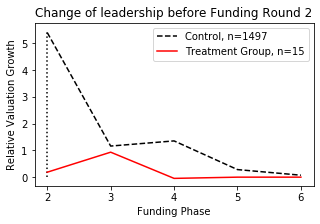

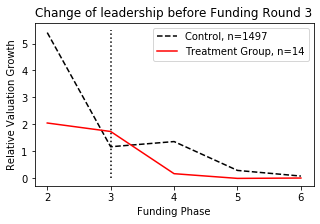

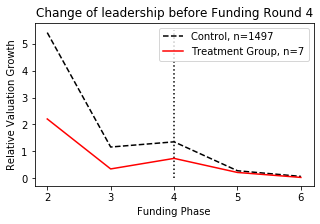

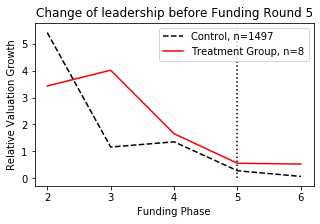

In [43]:
plt.figure(figsize=(5,3))
plt.plot(X[X.funding_round_num.isna()].iloc[:, 2:7].mean(), "k--")
plt.plot(X[X.funding_round_num == 2].iloc[:, 2:7].mean(), "r")
plt.vlines(2, ymin=0, ymax=5.5, linestyles="dotted")
plt.title("Change of leadership before Funding Round 2")

plt.legend([f"Control, n={(X.funding_round_num.isna()).sum()}",
            f"Treatment Group, n={(X.funding_round_num == 2).sum()}"])
plt.ylabel("Relative Valuation Growth")
plt.xlabel("Funding Phase")
plt.xticks([2,3,4,5,6])
plt.show()

plt.figure(figsize=(5,3))
plt.plot(X[X.funding_round_num.isna()].iloc[:, 2:7].mean(), "k--")
plt.plot(X[X.funding_round_num == 3].iloc[:, 2:7].mean(), "r")
plt.vlines(3, ymin=0, ymax=5.5, linestyles="dotted")
plt.title("Change of leadership before Funding Round 3")

plt.legend([f"Control, n={(X.funding_round_num.isna()).sum()}",
            f"Treatment Group, n={(X.funding_round_num == 3).sum()}"])
plt.ylabel("Relative Valuation Growth")
plt.xlabel("Funding Phase")
plt.xticks([2,3,4,5,6])
plt.show()


plt.figure(figsize=(5,3))
plt.plot(X[X.funding_round_num.isna()].iloc[:, 2:7].mean(), "k--")
plt.plot(X[X.funding_round_num == 4].iloc[:, 2:7].mean(), "r")
plt.vlines(4, ymin=0, ymax=5.5, linestyles="dotted")
plt.title("Change of leadership before Funding Round 4")

plt.legend([f"Control, n={(X.funding_round_num.isna()).sum()}",
            f"Treatment Group, n={(X.funding_round_num == 4).sum()}"])
plt.ylabel("Relative Valuation Growth")
plt.xlabel("Funding Phase")
plt.xticks([2,3,4,5,6])
plt.show()

plt.figure(figsize=(5,3))
plt.plot(X[X.funding_round_num.isna()].iloc[:, 2:7].mean(), "k--")
plt.plot(X[X.funding_round_num == 5].iloc[:, 2:7].mean(), "r")
plt.vlines(5, ymin=0, ymax=5.5, linestyles="dotted")
plt.title("Change of leadership before Funding Round 5")

plt.legend([f"Control, n={(X.funding_round_num.isna()).sum()}",
            f"Treatment Group, n={(X.funding_round_num == 5).sum()}"])
plt.ylabel("Relative Valuation Growth")
plt.xlabel("Funding Phase")
plt.xticks([2,3,4,5,6])
plt.show()

In [125]:
X

,object_id,1.0,2.0,3.0,4.0,5.0,6.0,funding_round_num,id,has_website
0,c:1,NaN,0.809524,1.631579,0.000000,0.000000,0.0,NaN,c:1,1.0
1,c:10015,NaN,3.500000,-0.770089,4.799343,2.583333,0.0,NaN,c:10015,1.0
2,c:100155,NaN,16.319801,-0.500000,0.000000,0.000000,0.0,NaN,c:100155,1.0
3,c:10018,NaN,0.250000,0.500000,0.000000,0.000000,0.0,NaN,c:10018,1.0
4,c:100238,NaN,1.424242,0.000000,0.000000,0.000000,0.0,NaN,c:100238,1.0
...,...,...,...,...,...,...,...,...,...,...
9521,c:98679,NaN,1.000000,-0.325000,0.000000,0.000000,0.0,NaN,c:98679,1.0
9523,c:990,NaN,1.000000,0.000000,0.000000,0.000000,0.0,NaN,c:990,1.0
9525,c:99231,NaN,0.555556,0.000000,0.000000,0.000000,0.0,NaN,c:99231,1.0
9526,c:9939,NaN,4.000000,0.000000,0.000000,0.000000,0.0,NaN,c:9939,1.0


In [126]:
funding = funding_rounds.pivot_table(values="raised_amount_usd",
                           index="object_id",
                           columns='funding_round_num')
funding = funding_matrix.reset_index()
funding = funding.merge(X[['id', 'funding_round_num']], left_on="object_id", right_on='id', how='right')

In [127]:
funding = funding.merge(objects[['id', 'category_code']], left_on='id', right_on='id', how='left')

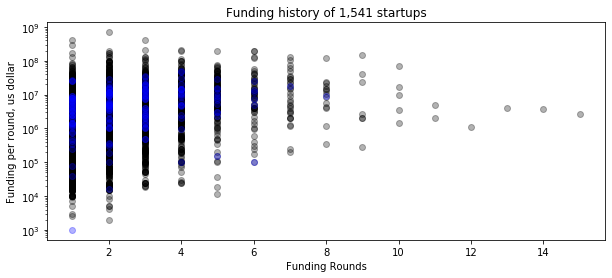

In [135]:
dat = funding.groupby("category_code").mean().T
plt.figure(figsize=(10,4))
plt.plot(funding[funding.funding_round_num.isna()].iloc[:, 1:-3].T,
         linestyle="None", marker="o", c='black', alpha=0.3)
plt.plot(funding[np.logical_not(funding.funding_round_num.isna())].iloc[:, 1:-3].T,
         linestyle="None", marker="o", c='blue', alpha=0.3)
# plt.legend(dat.columns)
plt.yscale("log")
plt.xlabel("Funding Rounds")
plt.title("Funding history of 1,541 startups")
hiplt.ylabel("Funding per round, us dollar")
plt.show()

# Model Building

In [16]:
X.to_csv("../data/synthetic_matrix.csv")

Continue to process this data with R, and read back the results

In [158]:
# estimated_matrix = pd.read_csv("../data/L0.csv", index_col=0).round(5)

# Use category
estimated_matrix = pd.read_csv("../data/L2.csv", delimiter=' ', header=None).round(5)

estimated_matrix.head()

,0,1,2,3
0,0.11228,0.11330,0.11567,0.11040
1,0.14745,0.14898,0.15217,0.14511
2,0.11658,0.11762,0.11988,0.11440
3,0.20520,0.20693,0.21156,0.20180
4,0.18427,0.18585,0.19020,0.18116


In [159]:
TrEffect = pd.concat([(X.iloc[:,2:-4] - np.array(estimated_matrix)),
                X.funding_round_num], axis=1)
TrEffect

,2.0,3.0,4.0,5.0,funding_round_num
0,0.697244,1.518279,-0.115670,-0.110400,NaN
1,3.352550,-0.919069,4.647173,2.438223,NaN
2,16.203221,-0.617620,-0.119880,-0.114400,NaN
3,0.044800,0.293070,-0.211560,-0.201800,NaN
4,1.239972,-0.185850,-0.190200,-0.181160,NaN
...,...,...,...,...,...
9521,0.862630,-0.463970,-0.142040,-0.135080,NaN
9523,0.856490,-0.145030,-0.147950,-0.141290,NaN
9525,0.410366,-0.146310,-0.149180,-0.142750,NaN
9526,3.843090,-0.158110,-0.161440,-0.154080,NaN


In [160]:
TrEffect4Tred = TrEffect.dropna()
one_term = []
for i in range(TrEffect4Tred.shape[0]):
  idx = TrEffect4Tred.iloc[i, -1]
  to_choose = int(max(0, idx-2))
  one_term.append(TrEffect4Tred.iloc[i, to_choose])

In [161]:
TrEffect4Tred['one_term']=one_term
TrEffect4Tred

/Users/chenyangzhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,2.0,3.0,4.0,5.0,funding_round_num,one_term
80,1.090830,1.349300,-0.153860,-0.146610,3.0,1.349300
123,-1.018580,0.553087,-0.115820,-0.110690,2.0,-1.018580
167,0.406046,-0.871423,-0.147350,-0.140850,2.0,0.406046
205,2.881050,-0.370110,-0.122870,-0.116980,2.0,2.881050
225,1.973357,-0.037175,-0.653565,1.360010,5.0,1.360010
245,2.408590,0.807020,0.364101,-0.369755,3.0,0.807020
327,1.243290,-0.474248,6.171891,-0.872460,5.0,-0.872460
353,3.100130,-0.403299,-0.162080,-0.154880,3.0,-0.403299
403,-1.050427,-0.128160,-0.130990,-0.125280,2.0,-1.050427
414,2.192003,-0.908977,0.282961,-0.686930,5.0,-0.686930


In [162]:
TrEffect4Tred[TrEffect4Tred.funding_round_num == 5]

,2.0,3.0,4.0,5.0,funding_round_num,one_term
225,1.973357,-0.037175,-0.653565,1.360010,5.0,1.360010
327,1.243290,-0.474248,6.171891,-0.872460,5.0,-0.872460
414,2.192003,-0.908977,0.282961,-0.686930,5.0,-0.686930
1087,-0.254120,1.195350,-0.777912,0.186920,5.0,0.186920
1121,3.294780,-0.957511,8.373770,-0.684537,5.0,-0.684537
1780,1.511199,1.064250,0.322434,-0.572000,5.0,-0.572000
2263,1.504915,1.006719,-0.662037,4.302575,5.0,4.302575
2275,14.821210,30.069470,-0.984170,0.324020,5.0,0.324020


([<matplotlib.axis.XTick at 0x7fc6ff467210>,
 <a list of 4 Text xticklabel objects>)

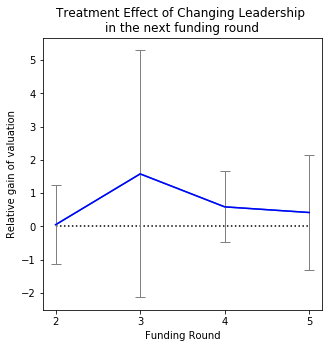

In [163]:
plt.figure(figsize=(5,5))
one_term_mean = TrEffect4Tred[['funding_round_num', 'one_term']].groupby("funding_round_num").mean().to_numpy().reshape([4])
one_term_error = TrEffect4Tred[['funding_round_num', 'one_term']].groupby("funding_round_num").std().to_numpy().reshape([4])
# plt.plot(TrEffect4Tred[['funding_round_num', 'one_term']].groupby("funding_round_num").mean())
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
plt.errorbar(x=[2,3,4,5], 
             y=one_term_mean,
             yerr=one_term_error,
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='grey')
plt.plot([2,3,4,5], one_term_mean, 'b-')
plt.title("Treatment Effect of Changing Leadership \nin the next funding round")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])

([<matplotlib.axis.XTick at 0x7fc72b159d90>,
 <a list of 4 Text xticklabel objects>)

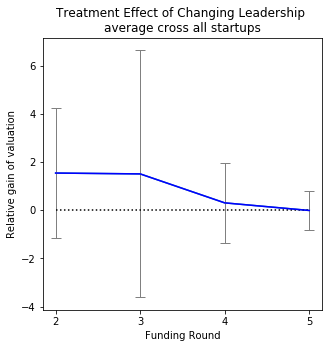

In [168]:
plt.figure(figsize=(5,5))
# plt.plot(X.iloc[1:6, 2:-3])
plt.errorbar(x=[2,3,4,5],
             y=TrEffect4Tred.iloc[:, :-2].mean(), 
             yerr=TrEffect4Tred.iloc[:, :-2].std(),
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='grey')
plt.plot(TrEffect4Tred.iloc[:, :-2].mean(), 'b-')
plt.title("Treatment Effect of Changing Leadership \naverage cross all startups")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])

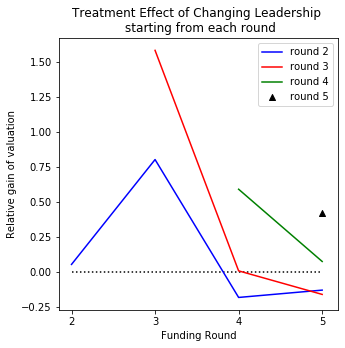

In [165]:
plt.figure(figsize=(5,5))
plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, :-2].mean(), 'b-', label="round 2")

plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==3].iloc[:, 1:-2].mean(), 'r-', label="round 3")

plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==4].iloc[:, 2:-2].mean(), 'g-', label="round 4")

plt.scatter(x=5, 
            y=TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, 3:-2].mean(),
            label="round 5", color="black", marker='^')

plt.title("Treatment Effect of Changing Leadership \n starting from each round")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])
plt.legend()
plt.show()

In [166]:
(TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, :-2].mean() + 1).cumprod()
(TrEffect4Tred[TrEffect4Tred['funding_round_num']==3].iloc[:, :-2].mean() + 1).cumprod()
(TrEffect4Tred[TrEffect4Tred['funding_round_num']==4].iloc[:, :-2].mean() + 1).cumprod()
(TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, :-2].mean() + 1).cumprod()

2.0     4.285829
3.0    20.870852
4.0    52.368546
5.0    74.347612
dtype: float64

([<matplotlib.axis.XTick at 0x7fc6fcca2ed0>,
 <a list of 4 Text xticklabel objects>)

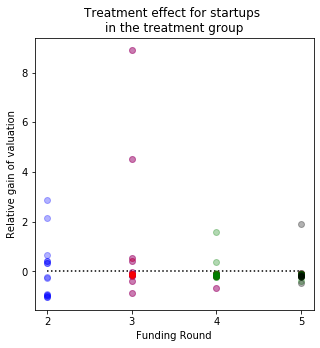

In [167]:
plt.figure(figsize=(5,5))

plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, :-2].T,
         linestyle="None", marker="o", c='blue', alpha=0.3)

plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, 1:-2].T,
         linestyle="None", marker="o", c='red', alpha=0.3)

plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==3].iloc[:, 2:-2].T,
         linestyle="None", marker="o", c='green', alpha=0.3)

plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==4].iloc[:, 3:-2].T,
         linestyle="None", marker="o", c='black', alpha=0.3)

plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")

plt.title("Treatment effect for startups \nin the treatment group")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])

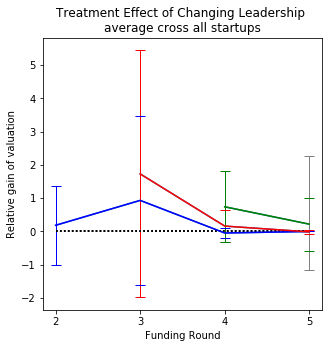

In [33]:
plt.figure(figsize=(5,5))
# plt.plot(X.iloc[1:6, 2:-3])
plt.errorbar(x=[2,3,4,5],
             y=TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, :-2].mean(), 
             yerr=TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, :-2].std(),
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='b')
plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==2].iloc[:, :-2].mean(), 'b-')
plt.title("Treatment Effect of Changing Leadership \n at Round 2")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])
# plt.show()

# plt.figure(figsize=(5,5))
# plt.plot(X.iloc[1:6, 2:-3])
plt.errorbar(x=[3,4,5],
             y=TrEffect4Tred[TrEffect4Tred['funding_round_num']==3].iloc[:, 1:-2].mean(), 
             yerr=TrEffect4Tred[TrEffect4Tred['funding_round_num']==3].iloc[:, 1:-2].std(),
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='red')
plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==3].iloc[:, 1:-2].mean(), 'r-')
plt.title("Treatment Effect of Changing Leadership \n at Round 3")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
# plt.xticks([2,3,4,5])
# plt.show()

# plt.figure(figsize=(5,5))
# plt.plot(X.iloc[1:6, 2:-3])
plt.errorbar(x=[4,5],
             y=TrEffect4Tred[TrEffect4Tred['funding_round_num']==4].iloc[:, 2:-2].mean(), 
             yerr=TrEffect4Tred[TrEffect4Tred['funding_round_num']==4].iloc[:, 2:-2].std(),
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='green')
plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==4].iloc[:, 2:-2].mean(), 'g-')
plt.title("Treatment Effect of Changing Leadership \n at Round 4")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
# plt.xticks([2,3,4,5])
# plt.show()

# plt.figure(figsize=(5,5))
# plt.plot(X.iloc[1:6, 2:-3])
plt.errorbar(x=[5],
             y=TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, 3:-2].mean(), 
             yerr=TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, 3:-2].std(),
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='grey')
plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, 3:-2].mean(), '-')
plt.title("Treatment Effect of Changing Leadership \naverage cross all startups")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])
plt.show()

([<matplotlib.axis.XTick at 0x7fc71440bf90>,
 <a list of 4 Text xticklabel objects>)

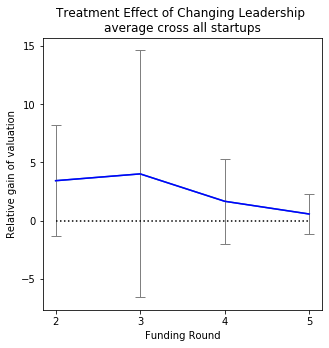

In [34]:
plt.figure(figsize=(5,5))
# plt.plot(X.iloc[1:6, 2:-3])
plt.errorbar(x=[2,3,4,5],
             y=TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, :-2].mean(), 
             yerr=TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, :-2].std(),
             barsabove=True,
             capsize=5, 
             elinewidth=1,
             markeredgewidth=1,
             ecolor='grey')
plt.plot(TrEffect4Tred[TrEffect4Tred['funding_round_num']==5].iloc[:, :-2].mean(), 'b-')
plt.title("Treatment Effect of Changing Leadership \naverage cross all startups")
plt.hlines(0, xmin=2, xmax=5, linestyles="dotted")
# plt.ylabel("Treatment Effect")
plt.ylabel("Relative gain of valuation")
plt.xlabel("Funding Round")
plt.xticks([2,3,4,5])

# Placebo Test

In [82]:
synthetic_x_0 = pd.read_csv("../data/synthetic_x_0.csv", index_col=0).round(5)

In [84]:
synthetic_x_0

,X2.0,X3.0,X4.0,X5.0
1,0.0,-0.0,-0.0,-0.0
2,-0.0,0.0,-0.0,0.0
3,-0.0,0.0,-0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
...,...,...,...,...
1493,0.0,0.0,0.0,0.0
1494,0.0,0.0,0.0,0.0
1495,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0
